# Test Uncertainty Propagation (UP) methods on Linear Freeflyer 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import time

import sys, os
sys.path.append('../..')
from models.freeflyer_linear import Model
import utils

from scipy.spatial import ConvexHull

# viz
import matplotlib.image as mpimg
img = mpimg.imread('figs/random_set_prop.png'); fig = plt.figure(figsize=(14, 6)); plt.imshow(img); plt.axis('off'); plt.show()

<Figure size 1400x600 with 1 Axes>

### Load Model + True Dynamics + Problem + Nominal Trajectory

In [2]:
# model + init
model = Model()
model.reset()
x_init = np.array([0.4,-0.3,0.0,0,0,0])+1e-6

[freeflyer_linear::__init__] Initializing freeflyer Model 
                             (linear, uncertain mass and inertia).
[freeflyer_linear::reset] resetting mass, J, and deltas.
[freeflyer_linear::reset] resetting mass, J, and deltas.


In [3]:
# nominal traj example
X_nom = np.load('data/Xtraj.npy'); #np.save('data/Xtraj', Xtraj)
U_nom = np.load('data/Utraj.npy'); #np.save('data/Utraj', Utraj)
X_nom.shape

(6, 14)

## Propagate Uncertainty

In [4]:
N_MC = 1000

In [5]:
Xs, Us = model.simulate_batch(x_init, X_nom, U_nom,
                             N_MC = N_MC)
Xs.shape

(1000, 6, 14)

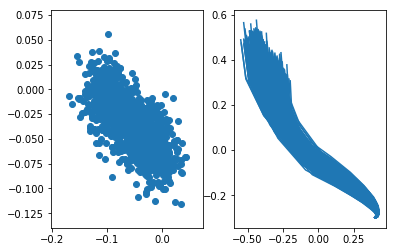

In [6]:
from utils.viz import plot_pts_2d, plot_trajs_2d
k = 10
plt.subplot(1,2,1)
plot_pts_2d(Xs[:,:,k])
plt.subplot(1,2,2)
plot_trajs_2d(Xs)

In [7]:
Xs_old = Xs.copy()

## Uncertainty propagation with adversarial sampling

In [8]:
# Simulate
# do not resample to reuse previously worse params
Xs, Us = model.simulate_batch(x_init, X_nom, U_nom,
                             N_MC = N_MC, B_resample = False)

In [9]:
# compute gradients
Xs_dms, Xs_dJs, Xs_dws = model.Xs_dparams_MC(X_nom, U_nom, Xs, Us)

In [10]:
Cs = np.mean(Xs,0) # (n_x, N)

In [11]:
# compute cost gradient
Jdists_dXs = np.swapaxes(Xs-Cs,1,0) / np.linalg.norm(Xs-Cs, axis=1) # (6, 1000, 14)

In [12]:
Jdist_dws = np.einsum('xMN,MxNtw->MNtw', Jdists_dXs, Xs_dws) 
Jdist_dms = np.einsum('xMN,MxN->MN', Jdists_dXs, Xs_dms) 
Jdist_dJs = np.einsum('xMN,MxN->MN', Jdists_dXs, Xs_dJs) 

In [13]:
# average over horizon (sum for each k)
Jdist_dws = np.mean(Jdist_dws, axis=1)
Jdist_dms = np.mean(Jdist_dms, axis=1)
Jdist_dJs = np.mean(Jdist_dJs, axis=1)

In [14]:
# gradient ascent
ms, Js, ws = model.masses_MC, model.Js_MC, model.ws_MC
ws_worse = ws + 1e-3*Jdist_dws
ms_worse = ms + 1e2*Jdist_dms
Js_worse = Js + 1e2*Jdist_dJs
# clip
for i in range(model.n_x):
    ws_worse[:,:,i] = np.clip(ws_worse[:,:,i], model.w_nom[i]-model.w_deltas[i], 
                                                 model.w_nom[i]+model.w_deltas[i])
ms_worse = np.clip(ms_worse, model.mass_nom-model.mass_deltas, model.mass_nom+model.mass_deltas)
Js_worse = np.clip(Js_worse, model.J_nom   -model.J_deltas,    model.J_nom+model.J_deltas)
# np.linalg.norm(ws_i-ws_i_worse)

In [15]:
# chance masses and inertias
ms_MC_old = model.masses_MC.copy()
Js_MC_old = model.Js_MC.copy()
model.masses_MC = ms_worse
model.Js_MC = Js_worse
# change disturbance i
ws_MC_old = model.ws_MC.copy()
model.ws_MC = ws_worse
print(np.linalg.norm(ms_MC_old-ms_worse))
print(np.linalg.norm(Js_MC_old-Js_worse))

17.03664725618975
0.17275038129077516


In [16]:
# resimulate
Xs_worse, Us_worse = model.simulate_batch(x_init, X_nom, U_nom,
                             N_MC = N_MC, B_resample = False)
Xs, Us = Xs_worse.copy(), Us_worse.copy()

In [17]:
Xs_old.shape

(1000, 6, 14)

Text(-0.005681039763472791, 0.06373860015510888, '($\\bf{robUP!}$)')

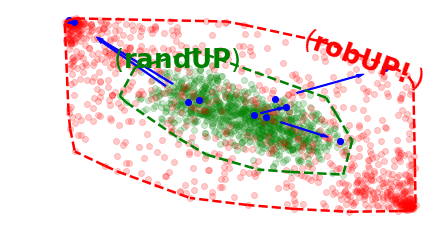

In [18]:
## plot change
k = 10

from matplotlib import rc
from matplotlib import rcParams

fig, ax = plt.subplots(figsize=(7, 4))
plt.axis('off')

plot_pts_2d(Xs_old[:,:,k],   alpha=0.2, color='g')
plot_pts_2d(Xs_worse[:,:,k], alpha=0.2, color='r')

idx = [0,1]
hull_unif = ConvexHull(Xs_old[:,idx,k])
for simplex in hull_unif.simplices:
    plt.plot(Xs_old[simplex, idx[0], k], Xs_old[simplex, idx[1], k], 'g--', linewidth=2.5)
hull_adv = ConvexHull(Xs_worse[:,idx,k])
for simplex in hull_adv.simplices:
    plt.plot(Xs_worse[simplex, idx[0], k], Xs_worse[simplex, idx[1], k], 'r--', linewidth=2.5)
    

idx_pts = [6, 35, 103, 233, 241]
for pt_i in idx_pts:
    xki, xki_worse = Xs_old[pt_i,:,k], Xs_worse[pt_i,:,k]
    plt.arrow(xki[0]+0.2*(xki_worse[0]-xki[0]), xki[1]+0.2*(xki_worse[1]-xki[1]), 
                     0.55*(xki_worse[0]-xki[0]),        0.55*(xki_worse[1]-xki[1]), 
              color="b", width=0.0015)
    plt.scatter(xki[0],       xki[1],       color='b')
    plt.scatter(xki_worse[0], xki_worse[1], color='b')
    
plt.text(xki[idx[0]]-0.14, xki[idx[1]]+0.07, '($\\bf{randUP}$)', color='g', fontsize=26)
plt.text(xki[idx[0]]+0.03, xki[idx[1]]+0.1, '($\\bf{robUP!}$)', color='r', fontsize=26, rotation=-20)

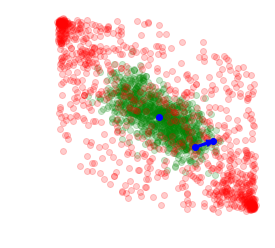

In [19]:
MC_i = 13
k = 10

plt.figure(figsize=(4,4))
plt.axis('off')

xki  = Xs_old[MC_i,:,k]

# plot change
plot_pts_2d(Xs_old[:,:,k],   alpha=0.2, color='g')
plot_pts_2d(Xs_worse[:,:,k], alpha=0.2, color='r')

plt.arrow(xki[0]+0.15*(xki_worse[0]-xki[0]), xki[1]+0.15*(xki_worse[1]-xki[1]), 
          0.5*(xki_worse[0]-xki[0]), 0.5*(xki_worse[1]-xki[1]), color="b", width=0.003)
plt.scatter(xki[0],       xki[1],       color='b')
plt.scatter(xki_worse[0], xki_worse[1], color='b')
plt.scatter(Cs[0,k], Cs[1,k], color='b')

dist          = np.linalg.norm(xki[:2]-Cs[:2,k])

dist_grad_xki = -(xki[:2]-Cs[:2,k]) / dist # (6, 1000, 14)